# Program Trading Simulation


In [1]:
colab = True

# Import Packages

In [2]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

    !cp /content/drive/MyDrive/NCCU/Paper/Program_Trading/TechIndex.py .
    !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
    !wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
    !dpkg -i libta.deb ta.deb
    !pip install ta-lib
    !pip install pandas_datareader --upgrade
    !pip install tensorflow_addons

import talib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import seaborn as sns

import pandas_datareader as pdr
import seaborn as sns
import datetime 
import requests
import os
import csv
import statistics
import math

from TechIndex import talib_index

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SpatialDropout2D, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D,MaxPooling1D,TimeDistributed
from tensorflow.keras.layers import Activation,Dense ,Dropout ,GRU, ConvLSTM2D ,LSTM ,Bidirectional,TimeDistributed,Flatten, Conv1D, MaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers 
from tensorflow.keras.layers import LayerNormalization
from tensorflow.python.keras.layers import Input, Embedding, Dot, Reshape, Dense
from tensorflow.python.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


Mounted at /content/drive
Selecting previously unselected package libta-lib0.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 270 kB 5.3 MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.21-cp37-cp37m-linux_x86_64.whl size=1444980 sha256=65be686d88302cecc89a4b3eb92dd1d7bef09f79776feeeca7d670ecfac05d08
  Stored in directory: /root/.cache/pip/wheels/32/3c/86/8dfaee7c11df54449f188172fcf66ae6d134f3118d0237df4a
Successful

# Define functions

In [1]:
def print_time(colab):
    now = datetime.datetime.now()
    if colab:
        now += datetime.timedelta(hours=8)
    print(now.strftime('%Y/%m/%d %H:%M:%S'),'\n')

def exponential_smoothing(days, alpha, numdata):
  # assign weights
  weights = []
  i = days 
  while i>0:
    weights.append( math.exp(-alpha*i) )
    # print(-alpha, i, int(-alpha*i), math.exp(-alpha*i))
    i-=1
  weights = np.array(weights) / sum(weights)
  # return data after smoothing
  results = []
  results += numdata[:days]
  for i in range(days, len(numdata)):
    # print(np.array(weights), np.array(numdata[i-days:i]) )
    results.append((np.dot( np.array(weights), np.array(numdata[i-days:i]))))
  return results

def to_onelist(text):
    onehot = [0] * 2
    onehot[int(classes.index(str(text)))] = 1
    label_list = np.array(onehot)
    return label_list

def count_label_dist(arr):
    count_1 = 0 
    count_0 = 0 
    for i in range(len(arr)):
        if list(arr[i])== list([0,1]): count_1 += 1
        elif list(arr[i])== list([1,0]): count_0 += 1
    print(count_0, count_1)
    return count_0, count_1
    
def save_pickle(var, path):
    with open( path,'wb') as f:
        pickle.dump(var, f)

def load_pickle(path):
    with open(path,'rb') as f:
        x = pickle.load(f) 
    return x

def loading_data_api(stock, start, end):
    s = start.split('/')
    e = end.split('/')
    start = datetime.datetime(int(s[0]), int(s[1]), int(s[2]))
    end = datetime.datetime(int(e[0]), int(e[1]), int(e[2]))

    # Loading price data from yahoo api 
    Price_df = pdr.DataReader(str(stock)+'.TW', 'yahoo', start=start, end=end)
    Return_Test_Stock_df = Price_df.copy(deep=True)
    Price_df.index = Price_df.index.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
    stock_time = str(Price_df.index[0]).split(" ")[0]
    
    # Loading Margin data from FinMind api 
    url = "https://api.finmindtrade.com/api/v3/data" #load in 融資融券
    parameter = {
        "dataset": "TaiwanStockMarginPurchaseShortSale",
        "stock_id": str(stock),
        "date": stock_time,
    }
    data = requests.get(url, params=parameter)
    data = data.json()
    data = pd.DataFrame(data['data'])
    data['b_total'] = data['MarginPurchaseLimit'] - data['MarginPurchaseTodayBalance']
    data['s_total'] = data['ShortSaleLimit'] - data['ShortSaleTodayBalance']
    data['b_s_ratio'] = (data['ShortSaleLimit'] - data['ShortSaleTodayBalance'])/(data['MarginPurchaseLimit'] - data['MarginPurchaseTodayBalance']+1)
    data = data.set_index('date')

    # 合併這兩個表格
    new_df = Price_df.join(data)
    new_df = new_df.drop(['stock_id'], axis=1)
    new_df = new_df.drop(['ShortSaleCashRepayment'], axis=1)
    new_df = new_df.drop(['MarginPurchaseLimit'], axis=1)
    new_df = new_df.drop(['ShortSaleLimit'], axis=1)
    
    # Loading Institutiona data from FinMind api 
    url = "https://api.finmindtrade.com/api/v3/data" #load in三大法人投資情況
    parameter = {
        "dataset": "InstitutionalInvestorsBuySell",
        "stock_id": str(stock),
        "date": stock_time,
    }
    data = requests.get(url, params=parameter)
    data = data.json()
    data = pd.DataFrame(data['data'])

    df = pd.DataFrame()
    z = 0 
    i = 0
    while i < len(data)  :
        a = data['date'][i]
        count = 0
        sell = 0
        buy = 0 
        if i+6 < len(data)-1:
            for j  in range(i, i+6):
                if data['date'][j]== a :
                    count += 1
                    sell += data['sell'][j]
                    buy += data['buy'][j]
        else:
            for j in range(i, len(data)):
                if data['date'][j] == a :
                    count += 1
                    sell += data['sell'][j]
                    buy += data['buy'][j]
        df = df.append({'date': a, 'buy_volume': buy, 'sell_volume':sell, 'bs_ratio':buy/(sell+1)}, ignore_index=True)
        i+=count

    new_df = new_df.join(df.set_index('date'))
    new_df = new_df.fillna(axis=0,method='ffill')
    new_df = new_df.drop(['Note'], axis=1)
    return new_df

def y_label(df):
    days = 5
    ans = [0]*days
    for i in range(days,len(df)):
        Pi = df['Close'][i]
        Pj = df['Close'][i-days]
        if Pi > Pj: 
            y = 1
        else: 
            y = 0
        ans.append(y)    
    df['y_label']= ans
    df['y_label_sum'] = df['y_label'].rolling(days).sum()
    df = df.iloc[days:,:]
    return df

def y_label_2(df, days, ratio):
    ans = [0]*days
    for i in range(days,len(df)):
        if i+days >= len(df):
            y = None
            ans.append(y)    
        else:    
            Pi = df['Close'][i]
            Pj = df['Close'][i+days]
            # print(i,Pi,Pi*1.01,Pj)
            if Pi * (1 + ratio) < Pj: 
                y = '1'
            else: 
                y = '0'
            ans.append(y)    
    df['y_label_2'] = ans
    df = df.iloc[:-days,:]
    return df   

def input_build(train_x,train_y,val_x,val_y,test_x,test_y):
    tr_va = int(len(new_x)*8/10)
    va_te = int(len(new_x)*9/10)

    train_x = train_x + new_x[:tr_va]
    train_y = train_y + y[:tr_va]
    val_x = val_x + new_x[tr_va: va_te]
    val_y = val_y + y[tr_va: va_te]
    test_x = test_x + new_x[va_te:]
    test_y = test_y +y[va_te:]
    return train_x,train_y,val_x,val_y,test_x,test_y

def normalization(df):
    for col in df.columns:
        if col == 'y_label' or col =='bs_ratio' or col =='b_s_ratio': continue
        mean = df[str(col)].mean()
        stdev = df[str(col)].std()
        if stdev == 0: 
            stdev = 1
        df[str(col)] = df[str(col)].apply(lambda x : (x-mean)/stdev)
    return df

def minmax(df):
    for col in df.columns:
        if col == 'y_label' or col =='bs_ratio' or col =='b_s_ratio': continue
        max = df[str(col)].max()
        min = df[str(col)].min()
        if min == 0: 
            min = 1
        df[str(col)] = df[str(col)].apply(lambda x : (x-min)/(max-min))
    return df    

def simple_strategy(predict, own_stock, left_money, price):
    if predict == 1:  # 如果預測漲
        if own_stock == 0: ## 手上沒有股票
            own_stock += int( left_money / ( price * (1 + 0.001425)) ) #買股票
            left_money = left_money - own_stock*price*(1 + 0.001425) #計算剩餘金額
    elif predict == 0 :  # 如果預測不會漲
        if own_stock > 0: ## 手上有股票
            left_money += own_stock*price*(1 - 0.001425 - 0.003)  # 賣出股票
            own_stock = 0
    stock_assets = left_money + own_stock * price    
    return stock_assets, own_stock, left_money


def simple_strategy_vote(predict, own_stock, left_money, price, recode, vote):
    days = sum(recode[-5:])
    if days >= vote:  # 如果預測漲
        if own_stock == 0: ## 手上沒有股票
            own_stock += int( left_money / ( price * (1 + 0.001425)) ) #買股票
            left_money = left_money - own_stock*price*(1 + 0.001425) #計算剩餘金額
    elif days < vote :  # 如果預測不會漲
        if own_stock > 0: ## 手上有股票
            left_money += own_stock*price*(1 - 0.001425 - 0.003)  # 賣出股票
            own_stock = 0
    stock_assets = left_money + own_stock * price    
    return stock_assets, own_stock, left_money    


# Config Setting

In [14]:
# # GPU Environment Setting
# gpus = tf.config.list_physical_devices("GPU")
# if gpus:
#     gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
#     tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
#     # 或者也可以设置GPU显存为固定使用量(例如：4G)
#     # tf.config.experimental.set_virtual_device_configuration(gpu0,
#     # [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
#     tf.config.set_visible_devices([gpu0],"GPU") 

# gd_root = '/content/drive/MyDrive/NCCU/Paper/Program_Trading_Code'
gd_root = '.'
if colab:
    gd_root = '/content/drive/MyDrive/NCCU/Paper/Program_Trading'
stock_root = 'stock'
assets_root = 'assets'
model_root = 'model'
data_root = 'data'

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('max_colwidth',100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None # ignore pandas warning

# data setting
time_slide = 40 
days = 5
ratio = 0.01

price = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
indicators = ['CMO', 'RSI', 'MACD', 'WILLR', 'slowk', 'slowd']
margin = [   
    'MarginPurchaseBuy', 'MarginPurchaseCashRepayment','MarginPurchaseSell', 'MarginPurchaseTodayBalance', 
    'MarginPurchaseYesterdayBalance', 'OffsetLoanAndShort','ShortSaleBuy', 'ShortSaleSell', 
    'ShortSaleTodayBalance', 'ShortSaleYesterdayBalance', 
    'b_total', 's_total','b_s_ratio', 'bs_ratio', 'buy_volume', 'sell_volume', 
]

feature = price + margin #+ indicators 

Update = False

classes =['0', '1']

# Y109Q2
stockNum = ["1101", "1102", "1216", "1301", "1326", "1402", "2002", "2105", "2207", 
            "2301", "2303", "2308", "2317", "2327", "2330", "2352", "2357", "2382", 
            "2395", "2408", "2412", "2454", "2474", "2609", "2610", "2801", #"2633",
            "2823", "2880", "2881", "2882", "2883", "2884", "2885", "2886", "2887", 
            "2888", "2890", "2891", "2892", "2912", "3008", "3045", "4904", #"3711",
            "4938",  "5880", "6505", "9904", "9910"] #"5871",
# stockNum = ["0050"] 


start = '2012/05/02'
end = '2020/09/21'
# s = start.split('/')
# e = end.split('/')
# start = datetime.datetime(int(s[0]), int(s[1]), int(s[2]))
# end = datetime.datetime(int(e[0]), int(e[1]), int(e[2]))

## function test

In [ ]:
df_test = loading_data_api('0050', start, end)

In [ ]:
df_test_2 = y_label(df_test)
df_test_22 = y_label_2(df_test_2)
df_test_222 = talib_index(df_test_22)
# display(df_test_2.head(6))
# display(df_test_22.head(6))
# display(df_test_2.tail(6))
display(df_test_222.tail(5))

,High,Low,Open,Close,Volume,Adj Close,MarginPurchaseBuy,MarginPurchaseCashRepayment,MarginPurchaseSell,MarginPurchaseTodayBalance,MarginPurchaseYesterdayBalance,OffsetLoanAndShort,ShortSaleBuy,ShortSaleSell,ShortSaleTodayBalance,ShortSaleYesterdayBalance,b_total,s_total,b_s_ratio,bs_ratio,buy_volume,sell_volume,y_label,y_label_sum,y_label_2,DEMA,upperband,middleband,lowerband,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,MIDPRICE,SAR,SAREXT,SMA,TRIMA,WMA,...,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,min,max,minidx,maxidx,MULT,SUB,SUM
2020-09-09,102.350,101.150,101.750,102.300,6274033.000,102.300,64.000,0.000,24.000,773.000,733.000,0.000,19.000,1.000,182.000,200.000,257102.000,257693.000,1.002,0.189,778000.000,4118000.000,0,1.000,1,104.768,103.470,102.710,101.950,102.271,103.620,103.674,103.640,103.175,103.425,47.450,47.450,103.640,103.761,103.366,...,0,0,0,0,0,1.081,0.793,102.567,-4.968,103.697,-0.087,0.380,102.480,0.144,1.561,103.000,-0.197,134059263277725738057488842351430597229936640.000,268118526555451476114977684702861194459873280.000,102.000,4.628,2.010,0.980,134059263277725738057488842351430597229936640.000,10.114,-4.978,1.000,203.500,1.012,105.600,2031,100.600,2034,100.600,105.600,2034,2031,10352.703,1.200,3109.200
2020-09-10,103.350,102.600,102.800,103.200,3581337.000,103.200,6.000,0.000,58.000,721.000,773.000,0.000,1.000,30.000,211.000,182.000,257154.000,257664.000,1.002,2.911,2486000.000,854000.000,0,1.000,1,104.723,103.390,102.690,101.990,102.331,103.629,103.671,103.612,103.175,103.425,47.450,47.450,103.612,103.688,103.338,...,0,0,0,0,0,1.102,0.792,102.537,-5.480,103.784,-0.096,0.350,102.441,0.122,1.561,104.000,-0.890,329730568515484157822420141261791035584937984.000,659461137030968315644840282523582071169875968.000,103.000,4.637,2.014,0.455,329730568515484157822420141261791035584937984.000,10.159,-0.511,1.000,205.950,1.007,105.600,2031,100.600,2034,100.600,105.600,2034,2031,10603.710,0.750,3108.350
2020-09-11,103.350,102.800,103.200,103.250,2905291.000,103.250,6.000,0.000,23.000,704.000,721.000,0.000,0.000,1.000,212.000,211.000,257171.000,257663.000,1.002,0.802,961197.000,1199000.000,1,2.000,1,104.684,103.634,102.830,102.026,102.390,103.629,103.668,103.593,103.175,103.425,47.450,47.450,103.593,103.630,103.315,...,0,0,0,0,0,1.470,0.786,102.551,-5.449,103.791,-0.095,0.402,102.456,0.162,1.561,104.000,-0.912,346637274123358019590280473945886155679465472.000,693274548246716039180560947891772311358930944.000,103.000,4.637,2.014,0.410,346637274123358019590280473945886155679465472.000,10.161,-0.450,1.000,206.150,1.005,105.600,2031,100.600,2034,100.600,105.600,2034,2031,10624.380,0.550,3107.800
2020-09-14,104.550,103.250,103.500,104.550,5753474.000,104.550,15.000,0.000,52.000,667.000,704.000,0.000,2.000,0.000,210.000,212.000,257208.000,257665.000,1.002,13.449,4613028.000,343000.000,1,2.000,0,104.805,104.718,103.260,101.802,102.530,103.602,103.681,103.678,103.175,103.425,47.450,47.450,103.678,103.583,103.376,...,0,0,0,0,0,1.025,0.783,103.010,-1.832,103.426,-0.032,0.729,102.978,0.531,1.561,105.000,-0.639,1271918876395901078138084018734174873944326144.000,2543837752791802156276168037468349747888652288.000,104.000,4.650,2.019,-0.769,1271918876395901078138084018734174873944326144.000,10.225,1.203,1.000,207.800,1.013,105.600,2031,100.600,2034,100.600,105.600,2034,2031,10794.788,1.300,3110.350
2020-09-15,105.200,104.250,104.450,104.950,5438768.000,104.950,59.000,0.000,32.000,694.000,667.000,1.000,24.000,1.000,187.000,210.000,257181.000,257688.000,1.002,4.262,4177050.000,980000.000,1,3.000,0,104.961,105.586,103.650,101.714,102.686,103.554,103.694,103.733,103.375,103.425,47.450,47.450,103.733,103.535,103.458,...,0,0,0,0,0,1.135,0.790,103.610,3.045,102.919,0.053,0.968,103.663,0.937,1.561,105.000,-0.289,1897468411940095865906035

# Model Training Phase

## FinMind Dictionary

In [ ]:
show_trans = True
if show_trans:
    url = "https://api.finmindtrade.com/api/v4/translation" #load in三大法人投資情況
    parameter = {
        "dataset": "TaiwanStockMarginPurchaseShortSale"
    }
    translation = requests.get(url, params=parameter)
    trans = translation.json()
    display(pd.DataFrame(trans['data']))

    url = "https://api.finmindtrade.com/api/v4/translation" #load in三大法人投資情況
    parameter = {
        "dataset": "TaiwanStockInstitutionalInvestorsBuySell",
    }
    translation = requests.get(url, params=parameter)
    trans = translation.json()
    display(pd.DataFrame(trans['data']))

    url = "https://api.finmindtrade.com/api/v4/data"
    parameter = {
        "dataset": "TaiwanStockInfo",
    }
    resp = requests.get(url, params=parameter)
    data = resp.json()
    data = pd.DataFrame(data["data"])
    display(data.head())

## Data Collection

In [ ]:
%%time
print_time(colab)

dwonload = True
counter = 0

if dwonload:
    for stock_num in stockNum:
        counter += 1
        miss_check = ''
        df = loading_data_api(stock_num, start, end)
        if df.isnull().sum().sum() >0:
            miss_check = "have missing value"
        df.to_csv(os.path.join(gd_root,stock_root,str(stock_num)+'.csv'))
        print(counter,str(stock_num),"download",miss_check)   

### Caculate Stdev to Filter Feature

In [ ]:
df_stock = pd.DataFrame()
df_std = pd.DataFrame()

for stock_num in stockNum:
    print('',stock_num+'\r',end ='\r')
    df = pd.read_csv(os.path.join(gd_root,stock_root,stock_num+'.csv'),index_col=0)
    df_describe = df.describe()
    df_describe = df_describe[df_describe.index=='std']
    df_describe['stock'] = str(stock_num)
    df_std = pd.concat([df_std,df_describe])

    df['stock'] = str(stock_num)
    df_stock = pd.concat([df_stock, df])
df_std = df_std.set_index('stock')    
feature_rank = df_std.mean().sort_values(ascending = False)
feature_rank = pd.DataFrame(feature_rank,columns = ['std'])
feature_rank['rank'] = feature_rank.rank(ascending=False).astype('int')
feature_rank.to_csv(os.path.join(gd_root,assets_root,'feature_rank.csv')) 
feature_rank

## Preprocess Training Data

In [15]:
%%time
print_time(colab)
print(f'slide winodw: {time_slide} days, {len(feature)} features')
print(f'predict {days} days after Close price rise {ratio*100} % \n')

train_x = []
test_x = []
val_x = []
val_y = []
train_y = []
test_y = []
counter=1
rank = 10
k = 10

# feature = list(feature_rank.loc[feature_rank['rank']<=k].index)
# if not 'Close' in feature:
#     feature += ['Close']

for stock_num in stockNum:
    new_x = []
    new_df = pd.read_csv(os.path.join(gd_root,stock_root,stock_num+'.csv'),index_col=0)
    new_df = talib_index(new_df)
    new_df = new_df[feature]

# smoothing
    for columnName in new_df.columns:
        new_df[str(columnName)] = exponential_smoothing(5, 0.2, list(new_df[str(columnName)]))

    # new_df = y_label(new_df)
    new_df = y_label_2(new_df, days=4, ratio = 0.01)
    new_df_y = new_df['y_label_2']
    new_df = new_df.drop(['y_label_2'],axis=1)

# normalization    
    for i in range(time_slide, len(new_df)): 
        tmp = new_df.copy(deep = True)
        tmp = tmp[i-time_slide:i]
        tmp = normalization(tmp)
        new_x.append(np.array(np.array(tmp).tolist()[0: time_slide]).reshape(time_slide,len(tmp.columns)))

# make lable y
    # y = list(new_df['y_label_2'][time_slide:])
    y = list(new_df_y[time_slide:])

    train_x,train_y,val_x,val_y,test_x,test_y = input_build(train_x,train_y,val_x,val_y,test_x,test_y)
    print(counter,str(stock_num),"loaded")
    counter += 1

# Convert raw data label to one-hot encoding
y = [] 
for i in range(len(train_y)):
    y.append(to_onelist(str(train_y[i])))
train_y = y

y = [] 
for i in range(len(test_y)):
    y.append(to_onelist(str(test_y[i])))
test_y = y

y = [] 
for i in range(len(val_y)):
    y.append(to_onelist(str(val_y[i])))
val_y = y

train_x = np.array(train_x)
test_x  = np.array(test_x)
val_x   = np.array(val_x)
train_y = np.array(train_y)
test_y  = np.array(test_y)
val_y   = np.array(val_y)

print(train_x.shape)   
print(train_y.shape)   
print(val_x.shape)   
print(val_y.shape)   
print(test_x.shape)   
print(test_y.shape)   

2021/10/07 21:58:33 

slide winodw: 30 days, 22 features
predict 5 days after Close price rise 1.0 % 

1 1101 loaded
2 1102 loaded
3 1216 loaded
4 1301 loaded
5 1326 loaded
6 1402 loaded
7 2002 loaded
8 2105 loaded
9 2207 loaded
10 2301 loaded
11 2303 loaded
12 2308 loaded
13 2317 loaded
14 2327 loaded
15 2330 loaded
16 2352 loaded
17 2357 loaded
18 2382 loaded
19 2395 loaded
20 2408 loaded
21 2412 loaded
22 2454 loaded
23 2474 loaded
24 2609 loaded
25 2610 loaded
26 2801 loaded
27 2823 loaded
28 2880 loaded
29 2881 loaded
30 2882 loaded
31 2883 loaded
32 2884 loaded
33 2885 loaded
34 2886 loaded
35 2887 loaded
36 2888 loaded
37 2890 loaded
38 2891 loaded
39 2892 loaded
40 2912 loaded
41 3008 loaded
42 3045 loaded
43 4904 loaded
44 4938 loaded
45 5880 loaded
46 6505 loaded
47 9904 loaded
48 9910 loaded
(77568, 30, 24)
(77568, 2)
(9696, 30, 24)
(9696, 2)
(9696, 30, 24)
(9696, 2)
CPU times: user 24min 40s, sys: 1min 25s, total: 26min 6s
Wall time: 24min 43s


### Save Pickle

In [ ]:
save_pickle(train_x, os.path.join(gd_root,data_root,'train_x.pkl'))
save_pickle(train_y, os.path.join(gd_root,data_root,'train_y.pkl'))
save_pickle(test_x, os.path.join(gd_root,data_root,'test_x.pkl'))
save_pickle(test_y, os.path.join(gd_root,data_root,'test_y.pkl'))
save_pickle(val_x, os.path.join(gd_root,data_root,'val_x.pkl'))
save_pickle(val_y, os.path.join(gd_root,data_root,'val_y.pkl'))

### Load pickle train/valid/test data

In [ ]:
train_x = load_pickle(os.path.join(gd_root,data_root,'train_x.pkl'))
train_y = load_pickle(os.path.join(gd_root,data_root,'train_y.pkl'))
test_x = load_pickle(os.path.join(gd_root,data_root,'test_x.pkl'))
test_y = load_pickle(os.path.join(gd_root,data_root,'test_y.pkl'))
val_x = load_pickle(os.path.join(gd_root,data_root,'val_x.pkl'))
val_y = load_pickle(os.path.join(gd_root,data_root,'val_y.pkl'))

## Model Build

In [30]:
%%time
print_time(colab)
print(f'slide winodw: {time_slide} days, {len(feature)} features')
print(f'predict {days} days after Close price rise {ratio*100} % \n')

def lstm4_model(input_shape , n_classes):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(input_shape[0],input_shape[1])))
    model.add(LSTM(25,return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(12,return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(6,return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(3,return_sequences=True))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(90, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
    model.add(BatchNormalization())
    model.add(Dense(25, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=20, decay_rate=0.9)
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])
    model.summary()
    return model

# def lstm4_model(input_shape , n_classes):
#     model = Sequential()
#     model.add(LSTM(64,return_sequences=True,input_shape=(input_shape[0],input_shape[1])))
#     model.add(LSTM(128,return_sequences=True))
#     model.add(LSTM(128,return_sequences=True))
#     model.add(LSTM(64,return_sequences=True))
#     model.add(Flatten())
#     # model.add(TimeDistributed(Dense(64, activation='relu')))
#     # model.add(TimeDistributed(Dense(32, activation='relu')))
#     model.add(Dense(2, activation='softmax'))
#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=20, decay_rate=0.9)
#     model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])
#     model.summary()
#     return model

# def lstm4_model(input_shape , n_classes):
#     model = Sequential()
#     model.add(LSTM(50,input_shape=(input_shape[0],input_shape[1]), return_sequences=True))
#     model.add(LSTM(50,return_sequences=True))
#     model.add(keras.layers.LayerNormalization(axis=1 , center=True , scale=True))
#     model.add(LSTM(50,return_sequences=True))
#     model.add(keras.layers.LayerNormalization(axis=1 , center=True , scale=True))
#     model.add(LSTM(50,return_sequences=True))
#     model.add(keras.layers.LayerNormalization(axis=1 , center=True , scale=True))
#     model.add(LSTM(50,return_sequences=True))
#     model.add(Flatten())
#     model.add(Dense(2, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(l=0.001)))
#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=20, decay_rate=0.9)
#     model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])
#     model.summary()
#     return model

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tf.keras.backend.clear_session()

model = lstm4_model((time_slide, train_x.shape[2]), 2)
callback = EarlyStopping(monitor="val_accuracy", patience=30, verbose=1, mode="auto")
input_dim_r = test_x.shape[1]
input_dim_c = test_x.shape[2]
model_prefix = 'lstm'
model_name = f'{model_prefix}_{input_dim_r}x{input_dim_c}.h5'
checkpoint = ModelCheckpoint(filepath=os.path.join(gd_root,model_root,model_name), 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             )

2021/10/07 23:46:55 

slide winodw: 30 days, 22 features
predict 5 days after Close price rise 1.0 % 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 30, 24)            96        
_________________________________________________________________
lstm (LSTM)                  (None, 30, 25)            5000      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 25)            100       
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 12)            1824      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 12)            48        
_____________________________________________________________

## Model Training

In [31]:
%%time
print_time(colab)
print(f'slide winodw: {time_slide} days, {len(feature)} features')
print(f'predict {days} days after Close price rise {ratio*100} % \n')

weight = {0: 0.7, 1: 0.3}

# start training
history = model.fit(train_x, train_y , epochs=100, batch_size= 256, validation_data=(val_x, val_y), callbacks=[callback, tensorboard_callback,checkpoint],class_weight= weight)  
model_history = pd.DataFrame(history.history)

2021/10/07 23:46:57 

slide winodw: 30 days, 22 features
predict 5 days after Close price rise 1.0 % 

Epoch 1/100
303/303 [==============================] - 25s 59ms/step - loss: 0.4469 - accuracy: 0.5298 - val_loss: 0.7077 - val_accuracy: 0.5670

Epoch 00001: val_accuracy improved from -inf to 0.56704, saving model to /content/drive/MyDrive/NCCU/Paper/Program_Trading/model/lstm_30x24.h5
Epoch 2/100
303/303 [==============================] - 15s 50ms/step - loss: 0.4220 - accuracy: 0.5501 - val_loss: 0.7289 - val_accuracy: 0.5332

Epoch 00002: val_accuracy did not improve from 0.56704
Epoch 3/100
303/303 [==============================] - 15s 50ms/step - loss: 0.4187 - accuracy: 0.5561 - val_loss: 0.7298 - val_accuracy: 0.5363

Epoch 00003: val_accuracy did not improve from 0.56704
Epoch 4/100
303/303 [==============================] - 15s 50ms/step - loss: 0.4183 - accuracy: 0.5559 - val_loss: 0.7296 - val_accuracy: 0.5377

Epoch 00004: val_accuracy did not improve from 0.56704
Epoch

KeyboardInterrupt: ignored

2021/10/07 22:31:40 

slide winodw: 30 days, 22 features
predict 5 days after Close price rise 1.0 % 

CPU times: user 144 ms, sys: 1.92 ms, total: 146 ms
Wall time: 146 ms


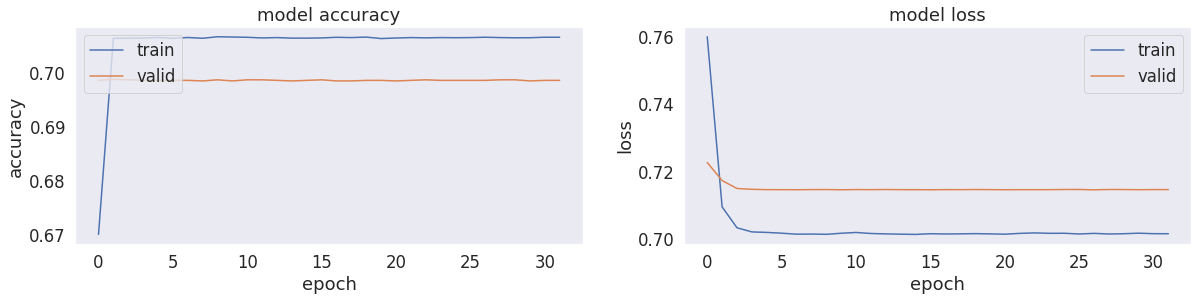

In [18]:
%%time
print_time(colab)
print(f'slide winodw: {time_slide} days, {len(feature)} features')
print(f'predict {days} days after Close price rise {ratio*100} % \n')

sns.set_style("dark")
fig, ax = plt.subplots(1,2,figsize=(20,4))
for col in model_history.columns:
    if 'accuracy' in col:
        sns.lineplot(x=model_history.index , y=col ,data=model_history, ax = ax[0])
    if 'loss' in col:
        sns.lineplot(x=model_history.index , y=col ,data=model_history, ax = ax[1])
ax[0].set_title('model accuracy')
ax[0].set_xlabel ('epoch')
ax[0].set_ylabel ('accuracy')
ax[0].legend(['train', 'valid'], loc='upper left')
ax[1].set_title('model loss')
ax[1].set_xlabel ('epoch')
ax[1].set_ylabel ('loss')
ax[1].legend(['train', 'valid'], loc='upper right')

## Model Performance

2021/10/07 22:31:41 

slide winodw: 30 days, 22 features
predict 5 days after Close price rise 1.0 % 

lstm_30x24_0.7039.h5
Precision:  0.18
Recall:  0.0
F1:  0.0
CPU times: user 5.88 s, sys: 375 ms, total: 6.25 s
Wall time: 8.62 s


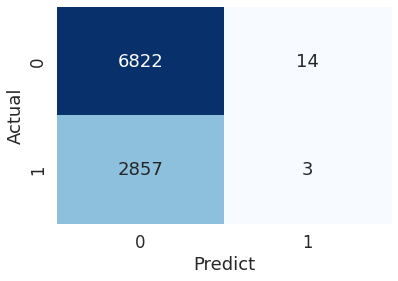

In [19]:
%%time
print_time(colab)
print(f'slide winodw: {time_slide} days, {len(feature)} features')
print(f'predict {days} days after Close price rise {ratio*100} % \n')

# save model
input_dim_r = test_x.shape[1]
input_dim_c = test_x.shape[2]
prediction_y = np.argmax(model.predict(test_x),axis=1)
truth_y = np.argmax(test_y,axis=1)
model_acc = accuracy_score(truth_y, prediction_y)
model_prefix = 'lstm'
model_name = f'{model_prefix}_{input_dim_r}x{input_dim_c}_{model_acc:.5}.h5'
model.save(os.path.join(gd_root,model_root,model_name))
# model_name = 'lstm_30x24_0.65347.h5'
print(model_name)
model = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_name))


# print("Accuracy: ", 1 - (np.sum(np.logical_xor(np.array(prediction_y), np.array(truth_y))))/len(test_y))
# print("Accuracy: ", round(accuracy_score(truth_y, prediction_y),2))
print("Precision: ", round(precision_score(truth_y, prediction_y),2))
print("Recall: ", round(recall_score(truth_y, prediction_y),2))
print("F1: ", round(f1_score(truth_y, prediction_y),2))

confusion = pd.DataFrame(confusion_matrix(truth_y,prediction_y),columns=[0,1])
confusion.index.name = 'Actual'
confusion.columns.name = 'Predict'

sns.set(style = 'white',font_scale=1.5)
sns.heatmap(confusion,cbar=False,annot=True,cmap='Blues', fmt='g')

# Validation ROR to Weight

## Validation Rate of Return

In [ ]:
%%time
# setting backtest model
# model_name = 'lstm_30x24_0.65347.h5'
model = tf.keras.models.load_model(os.path.join(gd_root,model_root,model_name))

# setiing stock portfolio for test
# stockNum = ["0050"]

# setting the information of data
start = '2018/08/01'
end = '2019/06/03'

# setting the information of data
asset_at_the_start = len(stockNum) * 10**6
total_asset_present_value = 0
Valid_ROR = {}
DIC_ROR = {}
record_ror = []
portfolio_list = []
counter = 0

for stock_num in stockNum:
    counter+=1
    new_df = loading_data_api(stock_num, start, end)
    Price_df = new_df.copy(deep=True)
    new_df = talib_index(new_df.astype('float'))
    new_df = new_df[feature]
    
# keep original data for plot
    new_df_ori = new_df.copy(deep=True)      

# smoothing
    for columnName in new_df.columns:
         new_df[str(columnName)] = exponential_smoothing(5, 0.2, list(new_df[str(columnName)]))

# make lable y
    new_df = y_label(new_df)
    new_df = y_label_2(new_df)
    new_df_y = new_df['y_label_2']
    new_df = new_df.drop(['y_label_2'],axis=1)
  
# start backtest evaluaion 
    y_preds_list=[]
    y_truth_list=[]

    left_money = asset_at_the_start*(1/len(stockNum))
    own_asset = left_money 
    time_slide = 30 
    own_stock = 0 
    money_record = [left_money]*time_slide
    stock_record = [[x,left_money] for x in new_df.index[:time_slide]]
    origin_hold_stock = 0 

    for i in range(time_slide, len(new_df)):
        tmp = new_df.copy(deep = True)
        tmp = new_df[i-time_slide:i]
        tmp = normalization(tmp)
        x = np.array(np.array(tmp).tolist()[0: time_slide]).reshape(time_slide,len(tmp.columns))
        predict = int(classes[np.argmax(model.predict(x.reshape(1,time_slide,len(tmp.columns))))])
        # y_truth_list.append(new_df['y_label'][i])
        y_preds_list.append(predict)

        price = int(Price_df['Close'][i]*100)/100
        # stock_assets, own_stock, left_money = simple_strategy(predict, own_stock, left_money, price)        
        stock_assets, own_stock, left_money = simple_strategy_vote(predict, own_stock, left_money, price, y_preds_list, 3)
        stock_record.append([new_df.index[i], stock_assets])

    daily_assets = pd.DataFrame(stock_record, columns = ['date',str(stock_num)]).set_index('date')  
    portfolio_list.append(daily_assets)
    last_money = stock_record[-1][1]
    left_assets = int(last_money)-(own_asset)
    record_ror.append([str(stock_num), int(last_money), left_assets/own_asset])
    print(str(counter).zfill(2),str(stock_num)+"最後資產 ：", int(last_money),"報酬率：",(left_assets*100)/own_asset,"%")
    total_asset_present_value += int(last_money)
    ROR = (left_assets*100/(own_asset))/100
    Valid_ROR[stock_num] = ROR

print("\n總投資報酬率：", (total_asset_present_value - asset_at_the_start)*100 / asset_at_the_start, "%\n")

Valid_Portfolio = portfolio_list[0].join(portfolio_list[1:])
Valid_Portfolio['total'] = Valid_Portfolio.sum(axis=1)
if len(stockNum) >= 45:
    save_pickle(Valid_Portfolio, os.path.join(gd_root,'Valid_Portfolio.pkl'))
    save_pickle(Valid_ROR, os.path.join(gd_root,'Valid_ROR.pkl'))
ror_df = pd.DataFrame(Valid_ROR.items(), columns = ['Stock','Valid_ROR'])
ror_df.to_csv(gd_root+'/Valid_ROR.csv')


01 1101最後資產 ： 1000000 報酬率： 0.0 %
02 1102最後資產 ： 1000000 報酬率： 0.0 %


KeyboardInterrupt: ignored

In [ ]:
# make y label before close smoothing
# 51 stocks 總投資報酬率： -5.479613725490196 %

# make y label after [close] smoothing
# 51 stocks 投資報酬率： -2.6800549019607844 %

## Convert ROR to Weights  
Filter ROR > 0 stock and normalize ROR to next step weight

In [ ]:
Valid_ROR = load_pickle(os.path.join(gd_root,'Valid_ROR.pkl'))
Valid_Weight = {}

for key in Valid_ROR:
  if Valid_ROR[key] > 0:
    Valid_Weight[key] = Valid_ROR[key]
WeightSum = sum(Valid_Weight.values())
NewWeightSum = 0
for key in Valid_Weight:
  Valid_Weight[key] /= WeightSum
  NewWeightSum += Valid_Weight[key]
if len(Valid_ROR) >= 45:
    save_pickle(Valid_Weight, os.path.join(gd_root,'Valid_Weight.pkl'))
    valid_weight_df = pd.DataFrame(Valid_Weight.items(), columns = ['Stock','Valid_ROR'])
    # valid_weight_df.to_csv(gd_root+'/valid_weight_df.csv')    
valid_weight_df

# Test Trading ROR

In [ ]:
# setting backtest model
model = tf.keras.models.load_model(os.path.join(gd_root,model_root, model_name))

# setting the information of data
start = '2019/06/25'
end = '2020/09/21'

Valid_Weight = load_pickle(os.path.join(gd_root,'Valid_Weight.pkl'))

# for test 
# stockNum = ['2207','2633','5871']

asset_at_the_start = len(Valid_Weight) * 10**6
total_asset_present_value = 0
stock_ror = []
ROR_Test = {}
counter = 0
portfolio_list = []
record_ror = []
Test_ROR = {}

time_point_asset = [0]*276

for stock_num in stockNum:
    if stock_num not in Valid_Weight.keys(): continue
    counter+=1
    new_df = loading_data_api(stock_num, start, end)
    new_df = talib_index(new_df)
    new_df = new_df[feature]
    
# smoothing
    for columnName in new_df.columns:
        new_df[str(columnName)] = exponential_smoothing(5, 0.2, list(new_df[str(columnName)]))

# make lable y
    new_df = y_label(new_df)
    new_df = y_label_2(new_df)
    new_df_y = new_df['y_label_2']
    new_df = new_df.drop(['y_label_2'],axis=1)

  # start evaluaion 
  ###############一般回測################################
    y_preds_list=[]
    # y_truth_list=[]
    left_money = asset_at_the_start * Valid_Weight[stock_num] #10**6
    init_money = left_money
    own_asset = left_money #10**6
    time_slide = 30 
    own_stock = 0 
    money_record = [left_money]*time_slide
    stock_record = [[x,left_money] for x in new_df.index[:time_slide]]
    origin_hold_stock = 0 

    for i in range(time_slide, len(new_df)): 
        tmp = new_df[i-time_slide:i]
        tmp = normalization(tmp)
        x = np.array(np.array(tmp).tolist()[0: time_slide]).reshape(time_slide,len(tmp.columns))
        predict = int(classes[np.argmax(model.predict(x.reshape(1,time_slide,len(tmp.columns))))])
        # y_truth_list.append(new_df['y_label'][i])
        y_preds_list.append(predict)

        price = int(new_df['Close'][i]*100)/100
        # stock_assets, own_stock, left_money = simple_strategy(predict, own_stock, left_money, price)
        stock_assets, own_stock, left_money = simple_strategy_vote(predict, own_stock, left_money, price, y_preds_list, 3)
        stock_record.append([new_df.index[i], stock_assets])

    daily_assets = pd.DataFrame(stock_record, columns = ['date',str(stock_num)]).set_index('date')  
    portfolio_list.append(daily_assets)
    last_money = stock_record[-1][1]
    left_assets = int(last_money)-(own_asset)
    record_ror.append([str(stock_num), int(last_money), left_assets/own_asset])
    print(str(counter).zfill(2),str(stock_num),"最後資產 ：", int(last_money),"報酬率：",(left_assets*100)/own_asset,"%")
    total_asset_present_value += int(last_money)
    ROR = (left_assets*100/(own_asset))/100
    Test_ROR[stock_num] = ROR

print("總投資報酬率：", (total_asset_present_value - asset_at_the_start)*100 / asset_at_the_start, "%\n")

Test_Portfolio = portfolio_list[0].join(portfolio_list[1:])
Test_Portfolio['total'] = Test_Portfolio.sum(axis=1)
if len(stockNum) >= len(Valid_Weight):
    save_pickle(Test_Portfolio, os.path.join(gd_root,'Test_Portfolio.pkl'))
    save_pickle(Test_ROR, os.path.join(gd_root,'Test_ROR.pkl'))
ror_df = pd.DataFrame(Test_ROR.items(), columns = ['Stock','Test_ROR'])
ror_df.to_csv(gd_root+'/Test_ROR.csv')

### NEW y_label


In [ ]:
# valida vote 1 weight
# test   vote 1
01 1101 最後資產 ： 688617 報酬率： 13.680100580468181 %
02 1102 最後資產 ： 1528962 報酬率： 4.319709728059638 %
03 1216 最後資產 ： 352914 報酬率： -13.92999085456852 %
04 2002 最後資產 ： 74533 報酬率： -10.372069797146175 %
05 2207 最後資產 ： 8926332 報酬率： 45.3089090811816 %
06 2301 最後資產 ： 1157879 報酬率： -0.8267257162948494 %
07 2308 最後資產 ： 1852078 報酬率： 25.00510231600089 %
08 2382 最後資產 ： 1136352 報酬率： 40.77098310359619 %
09 2395 最後資產 ： 1175183 報酬率： 22.74975117128824 %
10 2408 最後資產 ： 341120 報酬率： -21.836538980908582 %
11 2412 最後資產 ： 68935 報酬率： 1.5638859005858643 %
12 2454 最後資產 ： 2287821 報酬率： 88.86906957168193 %
13 2610 最後資產 ： 198995 報酬率： -0.2513170369418202 %
14 2801 最後資產 ： 286782 報酬率： -7.3125617380128425 %
15 2880 最後資產 ： 815405 報酬率： -5.612392749114652 %
16 2884 最後資產 ： 1293222 報酬率： 14.605485361738861 %
17 2885 最後資產 ： 1034458 報酬率： 10.3085084816152 %
18 2886 最後資產 ： 1088292 報酬率： -4.02025465595659 %
19 2890 最後資產 ： 510237 報酬率： -10.562902803755174 %
20 2892 最後資產 ： 544601 報酬率： -1.8966887340119805 %
21 3045 最後資產 ： 465191 報酬率： -10.489457270999461 %
22 4904 最後資產 ： 113827 報酬率： -13.44017956687156 %
23 5880 最後資產 ： 733053 報酬率： 1.997799110040149 %
24 9904 最後資產 ： 674429 報酬率： -27.020678261799016 %
25 9910 最後資產 ： 2145491 報酬率： -1.1523848747333103 %
總投資報酬率： 17.978836 %

# valida vote 1 weight
# test   vote 2
01 1101 最後資產 ： 697378 報酬率： 15.126407251935023 %
02 1102 最後資產 ： 1521863 報酬率： 3.835351307536763 %
03 1216 最後資產 ： 358247 報酬率： -12.629358522689971 %
04 2002 最後資產 ： 74726 報酬率： -10.139982124180497 %
05 2207 最後資產 ： 8754360 報酬率： 42.509431791684754 %
06 2301 最後資產 ： 1160342 報酬率： -0.6157677711548427 %
07 2308 最後資產 ： 1858196 報酬率： 25.418033745438148 %
08 2382 最後資產 ： 1122035 報酬率： 38.99739695679116 %
09 2395 最後資產 ： 1211818 報酬率： 26.576335740806474 %
10 2408 最後資產 ： 336336 報酬率： -22.932733861054377 %
11 2412 最後資產 ： 68991 報酬率： 1.6463922850122488 %
12 2454 最後資產 ： 2277586 報酬率： 88.02412806311717 %
13 2610 最後資產 ： 199647 報酬率： 0.07550595505252099 %
14 2801 最後資產 ： 285097 報酬率： -7.857150775928222 %
15 2880 最後資產 ： 812786 報酬率： -5.9155563836153835 %
16 2884 最後資產 ： 1293222 報酬率： 14.605485361738861 %
17 2885 最後資產 ： 983301 報酬率： 4.853427300558078 %
18 2886 最後資產 ： 1111740 報酬率： -1.9523049983030096 %
19 2890 最後資產 ： 527984 報酬率： -7.452112790600978 %
20 2892 最後資產 ： 551673 報酬率： -0.6227531054085309 %
21 3045 最後資產 ： 457817 報酬率： -11.908338423222204 %
22 4904 最後資產 ： 115379 報酬率： -12.259960099502523 %
23 5880 最後資產 ： 733716 報酬率： 2.090049657831314 %
24 9904 最後資產 ： 674798 報酬率： -26.98074912215437 %
25 9910 最後資產 ： 2126730 報酬率： -2.016746509140133 %
總投資報酬率： 17.263072 %

# valida vote 1 weight
# test   vote 3
01 1101 最後資產 ： 706167 報酬率： 16.577336293770664 %
02 1102 最後資產 ： 1510787 報酬率： 3.0796457341163714 %
03 1216 最後資產 ： 356095 報酬率： -13.154196470974734 %
04 2002 最後資產 ： 74951 報酬率： -9.86941359352103 %
05 2207 最後資產 ： 8568597 報酬率： 39.485455215679345 %
06 2301 最後資產 ： 1129258 報酬率： -3.278137550583169 %
07 2308 最後資產 ： 1868259 報酬率： 26.097231027953203 %
08 2382 最後資產 ： 1111681 報酬率： 37.714746194479275 %
09 2395 最後資產 ： 1195964 報酬率： 24.920359986332826 %
10 2408 最後資產 ： 334281 報酬率： -23.403611887538407 %
11 2412 最後資產 ： 69146 報酬率： 1.8747581704781342 %
12 2454 最後資產 ： 2281989 報酬率： 88.38761389235124 %
13 2610 最後資產 ： 200524 報酬率： 0.5151129550203696 %
14 2801 最後資產 ： 287965 報酬率： -6.930218217624775 %
15 2880 最後資產 ： 819365 報酬率： -5.154000999354096 %
16 2884 最後資產 ： 1294408 報酬率： 14.710588820881238 %
17 2885 最後資產 ： 973227 報酬率： 3.779195273309227 %
18 2886 最後資產 ： 1128340 報酬率： -0.48830106120605354 %
19 2890 最後資產 ： 545202 報酬率： -4.4340487546236895 %
20 2892 最後資產 ： 551723 報酬率： -0.6137462075818662 %
21 3045 最後資產 ： 444923 報酬率： -14.38936006368329 %
22 4904 最後資產 ： 115563 報酬率： -12.12003717295877 %
23 5880 最後資產 ： 734797 報酬率： 2.2404611844712066 %
24 9904 最後資產 ： 669194 報酬率： -27.587152641310396 %
25 9910 最後資產 ： 2144230 報酬率： -1.2104819922103638 %
總投資報酬率： 16.466544 %

# valida vote 2 weight
# test   vote 1
01 1101 最後資產 ： 617121 報酬率： 13.680225198440297 %
02 1102 最後資產 ： 1417057 報酬率： 4.3197160282014275 %
03 1216 最後資產 ： 494028 報酬率： -13.929244417921826 %
04 2002 最後資產 ： 38905 報酬率： -10.36744839015149 %
05 2207 最後資產 ： 9380930 報酬率： 45.31040929691623 %
06 2301 最後資產 ： 1236676 報酬率： -0.8265024287605421 %
07 2308 最後資產 ： 1932859 報酬率： 25.005387343824804 %
08 2382 最後資產 ： 917541 報酬率： 40.76863162685114 %
09 2395 最後資產 ： 939279 報酬率： 22.748713290957955 %
10 2408 最後資產 ： 163755 報酬率： -21.836464685108854 %
11 2412 最後資產 ： 97885 報酬率： 1.5613404648518259 %
12 2454 最後資產 ： 2570514 報酬率： 88.85298087252379 %
13 2610 最後資產 ： 166938 報酬率： -0.25129917314773814 %
14 2801 最後資產 ： 193809 報酬率： -7.312272823772215 %
15 2880 最後資產 ： 852245 報酬率： -5.612458267262482 %
16 2884 最後資產 ： 1320523 報酬率： 14.605593713286899 %
17 2885 最後資產 ： 1134605 報酬率： 10.308588544407097 %
18 2886 最後資產 ： 1132710 報酬率： -4.020264732515996 %
19 2890 最後資產 ： 491055 報酬率： -10.562762711018479 %
20 2892 最後資產 ： 529375 報酬率： -1.8967027003008734 %
21 3045 最後資產 ： 466565 報酬率： -10.490012472400345 %
22 4904 最後資產 ： 68191 報酬率： -13.434967962431477 %
23 5880 最後資產 ： 759774 報酬率： 1.9977467016140542 %
24 9904 最後資產 ： 740368 報酬率： -27.02009721787044 %
25 9910 最後資產 ： 2036245 報酬率： -1.1523532676651715 %
總投資報酬率： 18.795812 %

# valida vote 2 weight
# test   vote 2
1 1101 最後資產 ： 624970 報酬率： 15.126094140807446 %
2 1102 最後資產 ： 1410477 報酬率： 3.835315096223698 %
3 1216 最後資產 ： 501483 報酬率： -12.630416248537918 %
4 2002 最後資產 ： 39004 報酬率： -10.13936401515149 %
5 2207 最後資產 ： 9200103 報酬率： 42.50940285278612 %
6 2301 最後資產 ： 1239305 報酬率： -0.6156734605305543 %
7 2308 最後資產 ： 1939228 報酬率： 25.41729494390987 %
8 2382 最後資產 ： 905998 報酬率： 38.99771096513821 %
9 2395 最後資產 ： 968584 報酬率： 26.578407176365296 %
10 2408 最後資產 ： 161470 報酬率： -22.92714086717674 %
11 2412 最後資產 ： 97968 報酬率： 1.6474577581917933 %
12 2454 最後資產 ： 2559044 報酬率： 88.01029194314708 %
13 2610 最後資產 ： 167485 報酬率： 0.07554396234141465 %
14 2801 最後資產 ： 192670 報酬率： -7.856991186973735 %
15 2880 最後資產 ： 849507 報酬率： -5.9156962906762125 %
16 2884 最後資產 ： 1320523 報酬率： 14.605593713286899 %
17 2885 最後資產 ： 1078494 報酬率： 4.853363852276157 %
18 2886 最後資產 ： 1157115 報酬率： -1.9523166794371436 %
19 2890 最後資產 ： 508134 報酬率： -7.452116091681509 %
20 2892 最後資產 ： 536250 報酬率： -0.6226339042008848 %
21 3045 最後資產 ： 459173 報酬率： -11.908159628325064 %
22 4904 最後資產 ： 69119 報酬率： -12.256918810331296 %
23 5880 最後資產 ： 760461 報酬率： 2.0899747220306635 %
24 9904 最後資產 ： 740766 報酬率： -26.98086537464209 %
25 9910 最後資產 ： 2018441 報酬率： -2.0166321252793042 %
總投資報酬率： 18.023088 %

# valida vote 2 weight
# test   vote 3
01 1101 最後資產 ： 632848 報酬率： 16.577305190363873 %
02 1102 最後資產 ： 1400212 報酬率： 3.079634918905857 %
03 1216 最後資產 ： 498476 報酬率： -13.154303076886329 %
04 2002 最後資產 ： 39121 報酬率： -9.869809753787852 %
05 2207 最後資產 ： 9004893 報酬率： 39.48560403978453 %
06 2301 最後資產 ： 1206102 報酬率： -3.2783414834062823 %
07 2308 最後資產 ： 1949716 報酬率： 26.095594034770627 %
08 2382 最後資產 ： 897634 報酬率： 37.71451072130498 %
09 2395 最後資產 ： 955904 報酬率： 24.921334374216684 %
10 2408 最後資產 ： 160480 報酬率： -23.399687659407462 %
11 2412 最後資產 ： 98187 報酬率： 1.874682905679177 %
12 2454 最後資產 ： 2564311 報酬率： 88.3972529362619 %
13 2610 最後資產 ： 168221 報酬率： 0.5153182726156678 %
14 2801 最後資產 ： 194607 報酬率： -6.930635199685461 %
15 2880 最後資產 ： 856384 報酬率： -5.154057179275106 %
16 2884 最後資產 ： 1321731 報酬率： 14.710433657161902 %
17 2885 最後資產 ： 1067445 報酬率： 3.779157767491448 %
18 2886 最後資產 ： 1174393 報酬率： -0.4882721614655633 %
19 2890 最後資產 ： 524705 報酬率： -4.433992950453515 %
20 2892 最後資產 ： 536299 報酬率： -0.6135532684177721 %
21 3045 最後資產 ： 446238 報酬率： -14.389725302281537 %
22 4904 最後資產 ： 69228 報酬率： -12.118548812940219 %
23 5880 最後資產 ： 761582 報酬率： 2.240466149813806 %
24 9904 最後資產 ： 734612 報酬率： -27.58748035762518 %
25 9910 最後資產 ： 2035048 報酬率： -1.2104605352771756 %
總投資報酬率： 17.193508 %

# valida vote 3 weight
# test   vote 1
1 1101 最後資產 ： 728140 報酬率： 13.680256934129053 %
2 1102 最後資產 ： 1303407 報酬率： 4.31971886766838 %
3 1216 最後資產 ： 484405 報酬率： -13.930117586467597 %
4 2002 最後資產 ： 40959 報酬率： -10.367356835227271 %
5 2207 最後資產 ： 9797344 報酬率： 45.30912148474536 %
6 2301 最後資產 ： 1232359 報酬率： -0.8268579056275202 %
7 2308 最後資產 ： 1712622 報酬率： 25.00615143891348 %
8 2382 最後資產 ： 901871 報酬率： 40.77057942551587 %
9 2395 最後資產 ： 797018 報酬率： 22.746207561662093 %
10 2408 最後資產 ： 19571 報酬率： -21.8209425099395 %
11 2412 最後資產 ： 135994 報酬率： 1.5625108085748214 %
12 2454 最後資產 ： 2473548 報酬率： 88.86681547988901 %
13 2610 最後資產 ： 223757 報酬率： -0.2514991249718649 %
14 2801 最後資產 ： 203981 報酬率： -7.312194087042008 %
15 2880 最後資產 ： 897238 報酬率： -5.612520213166608 %
16 2884 最後資產 ： 1411450 報酬率： 14.605719613262915 %
17 2885 最後資產 ： 1132085 報酬率： 10.308559961630092 %
18 2886 最後資產 ： 1239415 報酬率： -4.020319310911039 %
19 2890 最後資產 ： 445334 報酬率： -10.563025788064893 %
20 2892 最後資產 ： 592622 報酬率： -1.8967266728431773 %
21 3045 最後資產 ： 482281 報酬率： -10.490138942428395 %
22 4904 最後資產 ： 141025 報酬率： -13.44489652073834 %
23 5880 最後資產 ： 824272 報酬率： 1.9977786482463213 %
24 9904 最後資產 ： 731717 報酬率： -27.02047841520943 %
25 9910 最後資產 ： 1808108 報酬率： -1.1524186752673151 %
總投資報酬率： 19.042092 %

# valida vote 3 weight
# test   vote 2
01 1101 最後資產 ： 737400 報酬率： 15.125966796531936 %
02 1102 最後資產 ： 1297355 報酬率： 3.835339898868052 %
03 1216 最後資產 ： 491723 報酬率： -12.629843230294085 %
04 2002 最後資產 ： 41064 報酬率： -10.137580045454545 %
05 2207 最後資產 ： 9608504 報酬率： 42.50834461081103 %
06 2301 最後資產 ： 1234982 報酬率： -0.6157739993035196 %
07 2308 最後資產 ： 1718260 報酬率： 25.417675220467494 %
08 2382 最後資產 ： 890513 報酬率： 38.99774024883205 %
09 2395 最後資產 ： 821911 報酬率： 26.579899328764533 %
10 2408 最後資產 ： 19296 報酬率： -22.91946792048401 %
11 2412 最後資產 ： 136108 報酬率： 1.647647845739531 %
12 2454 最後資產 ： 2462308 報酬率： 88.00858956068554 %
13 2610 最後資產 ： 224491 報酬率： 0.07571030151432619 %
14 2801 最後資產 ： 202782 報酬率： -7.857012865700985 %
15 2880 最後資產 ： 894357 報酬率： -5.915595126696649 %
16 2884 最後資產 ： 1411450 報酬率： 14.605719613262915 %
17 2885 最後資產 ： 1076099 報酬率： 4.853373259207728 %
18 2886 最後資產 ： 1266120 報酬率： -1.9522974031544598 %
19 2890 最後資產 ： 460824 報酬率： -7.452150062108924 %
20 2892 最後資產 ： 600318 報酬率： -0.6227226845913086 %
21 3045 最後資產 ： 474640 報酬率： -11.908284895391304 %
22 4904 最後資產 ： 142947 報酬率： -12.265255259351061 %
23 5880 最後資產 ： 825017 報酬率： 2.0899670825167362 %
24 9904 最後資產 ： 732108 報酬率： -26.98148110758961 %
25 9910 最後資產 ： 1792298 報酬率： -2.0167366588966247 %
總投資報酬率： 18.2515 %

# valida vote 3 weight
# test   vote 3


### OLD y_label


In [ ]:
# valida vote 1 weight
# test   vote 1
1 1101 最後資產 ： 148863 報酬率： -8.368289464691712 %
2 2207 最後資產 ： 8047460 報酬率： 65.80251522986912 %
3 2301 最後資產 ： 544756 報酬率： -26.296551472759546 %
4 2352 最後資產 ： 5314 報酬率： 7.036647404844267 %
5 2382 最後資產 ： 125513 報酬率： -3.1906970323232926 %
6 2395 最後資產 ： 1463464 報酬率： 11.44672606275469 %
7 2633 最後資產 ： 2118703 報酬率： -6.187064055768314 %
8 2880 最後資產 ： 705909 報酬率： -1.7659624103530056 %
9 2884 最後資產 ： 1923434 報酬率： 9.426449564514487 %
10 2885 最後資產 ： 789193 報酬率： 1.9950674811007671 %
11 2886 最後資產 ： 914744 報酬率： -4.463284408013486 %
12 2890 最後資產 ： 368915 報酬率： -10.229172297509125 %
13 2892 最後資產 ： 509337 報酬率： 3.010414618110616 %
14 3008 最後資產 ： 321504 報酬率： -25.786688408728043 %
15 5871 最後資產 ： 314653 報酬率： -9.966810702583844 %
16 5880 最後資產 ： 648154 報酬率： 5.443193763605664 %
17 9904 最後資產 ： 770153 報酬率： -25.097412025826245 %
總投資報酬率： 16.00040588235294 %

# valida vote 1 weight
# test   vote 2
1 1101 最後資產 ： 148228 報酬率： -8.75915983671109 %
2 2207 最後資產 ： 8569248 報酬率： 76.55295857680876 %
3 2301 最後資產 ： 535806 報酬率： -27.5074529852143 %
4 2352 最後資產 ： 6380 報酬率： 28.50843252595153 %
5 2382 最後資產 ： 137301 報酬率： 5.901493126329381 %
6 2395 最後資產 ： 1480475 報酬率： 12.742159539118658 %
7 2633 最後資產 ： 2492364 報酬率： 10.35807486075635 %
8 2880 最後資產 ： 742748 報酬率： 3.3605393211237224 %
9 2884 最後資產 ： 2217577 報酬率： 26.160594928615872 %
10 2885 最後資產 ： 888583 報酬率： 14.840201379838598 %
11 2886 最後資產 ： 1007240 報酬率： 5.197084006970799 %
12 2890 最後資產 ： 389623 報酬率： -5.190140813120633 %
13 2892 最後資產 ： 533806 報酬率： 7.959126051386716 %
14 3008 最後資產 ： 379879 報酬率： -12.311888517776453 %
15 5871 最後資產 ： 450711 報酬率： 28.96412486589269 %
16 5880 最後資產 ： 648571 報酬率： 5.511032289325514 %
17 9904 最後資產 ： 803613 報酬率： -21.84320072805054 %
總投資報酬率： 26.07148823529412 %

# valida vote 1 weight
# test   vote 3
1 1101 最後資產 ： 149604 報酬率： -7.912171440020279 %
2 2207 最後資產 ： 7819266 報酬率： 61.10101448797481 %
3 2301 最後資產 ： 670731 報酬率： -9.252605323989973 %
4 2352 最後資產 ： 5905 報酬率： 18.940798442906548 %
5 2382 最後資產 ： 142244 報酬率： 9.714073373548601 %
6 2395 最後資產 ： 1517334 報酬率： 15.54907168451279 %
7 2633 最後資產 ： 2434929 報酬率： 7.814940699924489 %
8 2880 最後資產 ： 705829 報酬率： -1.7770951810177398 %
9 2884 最後資產 ： 2059400 報酬率： 17.161717133606423 %
10 2885 最後資產 ： 783738 報酬率： 1.2900649112485199 %
11 2886 最後資產 ： 967604 報酬率： 1.0574632396260797 %
12 2890 最後資產 ： 363818 報酬率： -11.46946317426826 %
13 2892 最後資產 ： 531119 報酬率： 7.415696094248586 %
14 3008 最後資產 ： 444813 報酬率： 2.676936426447114 %
15 5871 最後資產 ： 375066 報酬率： 7.319454055816051 %
16 5880 最後資產 ： 640952 報酬率： 4.271555724674348 %
17 9904 最後資產 ： 859968 報酬率： -16.362295836055623 %
總投資報酬率： 20.42541176470588 %

# valida vote 2 weight
# test   vote 1
1 1101 最後資產 ： 326739 報酬率： -6.2518518094309155 %
2 1102 最後資產 ： 1266117 報酬率： -6.666099909716208 %
3 2207 最後資產 ： 10878096 報酬率： 98.20199360056684 %
4 2301 最後資產 ： 454355 報酬率： -15.63973362424164 %
5 2317 最後資產 ： 19398 報酬率： -15.771497047868664 %
6 2352 最後資產 ： 1112505 報酬率： 33.105630938454745 %
7 2382 最後資產 ： 539216 報酬率： 7.4062528393467995 %
8 2395 最後資產 ： 420151 報酬率： 31.984290098204557 %
9 2454 最後資產 ： 448960 報酬率： 69.19833702605055 %
10 2610 最後資產 ： 243350 報酬率： -11.41044244486786 %
11 2633 最後資產 ： 4254220 報酬率： 3.1070007811600613 %
12 2880 最後資產 ： 745635 報酬率： 7.539171595620026 %
13 2884 最後資產 ： 2278447 報酬率： 23.261151116721802 %
14 2885 最後資產 ： 973766 報酬率： 22.863542881251465 %
15 2886 最後資產 ： 1575532 報酬率： 5.910538369713379 %
16 2890 最後資產 ： 632794 報酬率： -10.869216771995047 %
17 2892 最後資產 ： 407513 報酬率： 6.8623330749300075 %
18 3008 最後資產 ： 189704 報酬率： -32.29643785578021 %
19 4938 最後資產 ： 162563 報酬率： 20.462870437771485 %
20 5871 最後資產 ： 604554 報酬率： 30.340111077281886 %
21 5880 最後資產 ： 385929 報酬率： 4.508959282225336 %
22 9904 最後資產 ： 662357 報酬率： -12.976458827678984 %
總投資報酬率： 29.917731818181817 %

# valida vote 2 weight
# test   vote 2
1 1101 最後資產 ： 318006 報酬率： -8.757529362916236 %
2 1102 最後資產 ： 1147085 報酬率： -15.440739848637067 %
3 2207 最後資產 ： 9690097 報酬率： 76.5563149638385 %
4 2301 最後資產 ： 390438 報酬率： -27.507227425210807 %
5 2317 最後資產 ： 18329 報酬率： -20.41322658987446 %
6 2352 最後資產 ： 1074813 報酬率： 28.595972607631747 %
7 2382 最後資產 ： 531680 報酬率： 5.905159545755145 %
8 2395 最後資產 ： 358835 報酬率： 12.722765713729666 %
9 2454 最後資產 ： 397070 報酬率： 49.64269352043366 %
10 2610 最後資產 ： 299518 報酬率： 9.037054036564902 %
11 2633 最後資產 ： 4553397 報酬率： 10.357975853606979 %
12 2880 最後資產 ： 716661 報酬率： 3.360397855369776 %
13 2884 最後資產 ： 2332045 報酬率： 26.16073630678945 %
14 2885 最後資產 ： 910176 報酬率： 14.840164891242797 %
15 2886 最後資產 ： 1564917 報酬率： 5.196975989009905 %
16 2890 最後資產 ： 673114 報酬率： -5.190033373048218 %
17 2892 最後資產 ： 411695 報酬率： 7.958980977989192 %
18 3008 最後資產 ： 245986 報酬率： -12.209924737443343 %
19 4938 最後資產 ： 154782 報酬率： 14.696972940331726 %
20 5871 最後資產 ： 598182 報酬率： 28.966326125425738 %
21 5880 最後資產 ： 389628 報酬率： 5.510642598029413 %
22 9904 最後資產 ： 594871 報酬率： -21.843083170073275 %
總投資報酬率： 24.415113636363635 %

# valida vote 2 weight
# test   vote 3
1 1101 最後資產 ： 320950 報酬率： -7.912835132129474 %
2 1102 最後資產 ： 1175880 報酬率： -13.31806899507478 %
3 2207 最後資產 ： 8841995 報酬率： 61.10365604479349 %
4 2301 最後資產 ： 488758 報酬率： -9.252115475161702 %
5 2317 最後資產 ： 23500 報酬率： 2.0398917092012767 %
6 2352 最後資產 ： 994469 報酬率： 18.983216878786294 %
7 2382 最後資產 ： 550818 報酬率： 9.71725129904032 %
8 2395 最後資產 ： 367814 報酬率： 15.543387206459133 %
9 2454 最後資產 ： 428508 報酬率： 61.4906472789533 %
10 2610 最後資產 ： 273763 報酬率： -0.33884099048432087 %
11 2633 最後資產 ： 4448474 報酬率： 7.815019484880946 %
12 2880 最後資產 ： 681040 報酬率： -1.77703913646615 %
13 2884 最後資產 ： 2165701 報酬率： 17.16173263395441 %
14 2885 最後資產 ： 802784 報酬率： 1.2901317240307995 %
15 2886 最後資產 ： 1503338 報酬率： 1.0575075159680496 %
16 2890 最後資產 ： 628531 報酬率： -11.469672100112863 %
17 2892 最後資產 ： 409623 報酬率： 7.415639405741791 %
18 3008 最後資產 ： 287996 報酬率： 2.783046658408474 %
19 4938 最後資產 ： 152537 報酬率： 13.033377016703367 %
20 5871 最後資產 ： 497788 報酬率： 7.321667233924504 %
21 5880 最後資產 ： 385052 報酬率： 4.271469077315855 %
22 9904 最後資產 ： 636585 報酬率： -16.36250397114853 %
總投資報酬率： 18.48138181818182 %

# valida vote 3 weight
# test   vote 1
1 1101 最後資產 ： 206755 報酬率： -6.250926978528824 %
2 1102 最後資產 ： 905483 報酬率： -6.665897930965227 %
3 2207 最後資產 ： 10517742 報酬率： 98.20578185262266 %
4 2301 最後資產 ： 1015551 報酬率： -15.640671173458266 %
5 2317 最後資產 ： 328175 報酬率： -15.82768195246005 %
6 2382 最後資產 ： 614869 報酬率： 7.405877422865956 %
7 2395 最後資產 ： 118144 報酬率： 31.96956930230334 %
8 2474 最後資產 ： 155178 報酬率： -12.05904750380854 %
9 2633 最後資產 ： 3073599 報酬率： 3.1070043759077555 %
10 2880 最後資產 ： 332166 報酬率： 7.539202666515348 %
11 2884 最後資產 ： 2496362 報酬率： 23.261009752462847 %
12 2885 最後資產 ： 1111313 報酬率： 22.863567056313194 %
13 2886 最後資產 ： 1052898 報酬率： 5.9105389473684085 %
14 2890 最後資產 ： 378152 報酬率： -10.868924777406983 %
15 2892 最後資產 ： 278576 報酬率： 6.862487242776752 %
16 3008 最後資產 ： 545986 報酬率： -32.451474827129324 %
17 4938 最後資產 ： 995224 報酬率： 20.468666418146316 %
18 9904 最後資產 ： 322813 報酬率： -12.976383741504685 %
19 9910 最後資產 ： 211280 報酬率： 26.844001754984628 %
總投資報酬率： 29.790873684210528 %

# valida vote 3 weight
# test   vote 2
1 1101 最後資產 ： 201226 報酬率： -8.757945549957395 %
2 1102 最後資產 ： 820354 報酬率： -15.440705160957242 %
3 2207 最後資產 ： 9368736 報酬率： 76.55288025232151 %
4 2301 最後資產 ： 872697 報酬率： -27.507202307972232 %
5 2317 最後資產 ： 310079 報酬率： -20.469053986857194 %
6 2382 最後資產 ： 606285 報酬率： 5.906416477855097 %
7 2395 最後資產 ： 100909 報酬率： 12.717677315192713 %
8 2474 最後資產 ： 146879 報酬率： -16.762175297477057 %
9 2633 最後資產 ： 3289747 報酬率： 10.357908863397409 %
10 2880 最後資產 ： 319259 報酬率： 3.360543535789406 %
11 2884 最後資產 ： 2555089 報酬率： 26.160729152026246 %
12 2885 最後資產 ： 1038742 報酬率： 14.840326146827115 %
13 2886 最後資產 ： 1045805 報酬率： 5.197057249470147 %
14 2890 最後資產 ： 402245 報酬率： -5.190163339313482 %
15 2892 最後資產 ： 281434 報酬率： 7.9588235694519 %
16 3008 最後資產 ： 708026 報酬率： -12.404142076817104 %
17 4938 最後資產 ： 947582 報酬率： 14.7017554458493 %
18 9904 最後資產 ： 289923 報酬率： -21.84283812451253 %
19 9910 最後資產 ： 220215 報酬率： 32.208215857979646 %
總投資報酬率： 23.81701052631579 %

# valida vote 3 weight
# test   vote 3
1 1101 最後資產 ： 203089 報酬率： -7.913204077978478 %
2 1102 最後資產 ： 840947 報酬率： -13.31804889473509 %
3 2207 最後資產 ： 8548904 報酬率： 61.1032293150957 %
4 2301 最後資產 ： 1092451 報酬率： -9.252776930076044 %
5 2317 最後資產 ： 397858 報酬率： 2.045037293389652 %
6 2382 最後資產 ： 628101 報酬率： 9.717255244905061 %
7 2395 最後資產 ： 103466 報酬率： 15.573905212555166 %
8 2474 最後資產 ： 140479 報酬率： -20.389120457072007 %
9 2633 最後資產 ： 3213941 報酬率： 7.814919496951082 %
10 2880 最後資產 ： 303390 報酬率： -1.7770671983463338 %
11 2884 最後資產 ： 2372835 報酬率： 17.161708949257033 %
12 2885 最後資產 ： 916180 報酬率： 1.2902241453605083 %
13 2886 最後資產 ： 1004651 報酬率： 1.0573947941895783 %
14 2890 最後資產 ： 375604 報酬率： -11.469492749193902 %
15 2892 最後資產 ： 280018 報酬率： 7.415642240350427 %
16 3008 最後資產 ： 830206 報酬率： 2.711774458810806 %
17 4938 最後資產 ： 933824 報酬率： 13.036393765884933 %
18 9904 最後資產 ： 310255 報酬率： -16.36175723319859 %
19 9910 最後資產 ： 208061 報酬率： 24.91144381457713 %
總投資報酬率： 19.496105263157894 %

# Figure Plot 

## Valid Portfolio Assets Change


In [ ]:
start = '2018/08/01'
end = '2019/06/03'
bench_df = loading_data_api(str('0050'), start, end)
twii_df = pdr.DataReader('^TWII', 'yahoo', start=start, end=end)

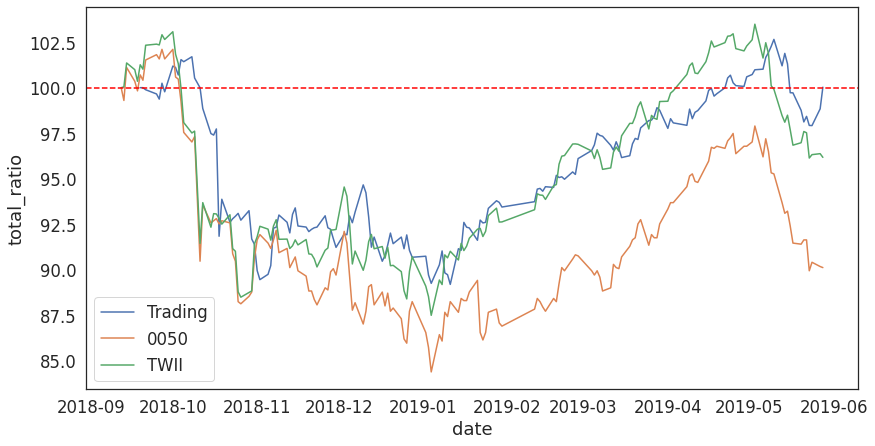

In [ ]:
# Valid_Portfolio = load_pickle(os.path.join(gd_root,'Valid_Portfolio.pkl'))
Valid_Portfolio.index = pd.to_datetime(Valid_Portfolio.index)
Valid_Portfolio['total_ratio'] = (Valid_Portfolio['total']/Valid_Portfolio['total'][0])*100
Valid = Valid_Portfolio[30:]
Benchmark = bench_df[30:-5]
Benchmark.index = pd.to_datetime(Benchmark.index)
Benchmark['ratio'] = (Benchmark['Close']/Benchmark['Close'][0])*100
TWII = twii_df[30:-5]
TWII.index = pd.to_datetime(TWII.index)
TWII['ratio'] = (TWII['Close']/TWII['Close'][0])*100

sns.set(style = 'white',font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
# fig.suptitle('Valid Portfolio Assets Change')
sns.lineplot(data = Valid,x=Valid.index,y='total_ratio',label="Trading")
sns.lineplot(data = Benchmark, x =Benchmark.index, y = 'ratio', label="0050")
sns.lineplot(data = TWII, x = TWII.index, y = 'ratio', label="TWII")

ax.axhline(100, ls='--',color='red')
plt.tight_layout(pad=0)
plt.savefig('Valid_Portfolio Assets Change.svg', dpi=300)
plt.savefig('Valid_Portfolio Assets Change.jpg')

## Valid Stock ROR


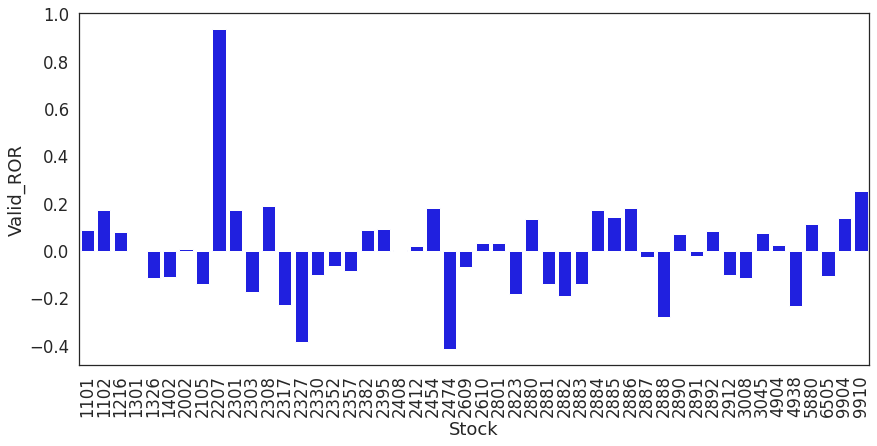

In [ ]:
Valid_ROR = load_pickle(os.path.join(gd_root,'Valid_ROR.pkl'))
ror_df = pd.DataFrame(Valid_ROR.items(), columns = ['Stock','Valid_ROR'])

sns.set(style = 'white',font_scale=1.5)
fig, ax = plt.subplots(figsize = (12,6),sharex = True)
# fig.suptitle('Valid Stock ROR')
ax = sns.barplot(x="Stock", y="Valid_ROR", data=ror_df,color = 'blue')
plt.xticks(rotation=90)
plt.tight_layout(pad=0)
plt.savefig('Valid Stock ROR.svg', dpi=300)
plt.savefig('Valid Stock ROR.jpg')

## Test Portfolio Assets Change


In [ ]:
start = '2019/06/25'
end = '2020/09/21'
bench_df_test = loading_data_api(str('0050'), start, end)
twii_df_test = pdr.DataReader('^TWII', 'yahoo', start=start, end=end)

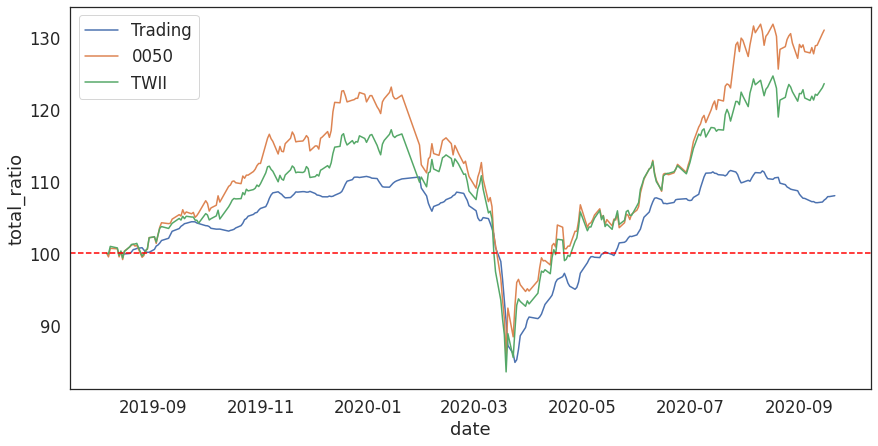

In [ ]:
# Test_Portfolio = load_pickle(os.path.join(gd_root,'Test_Portfolio.pkl'))
Test_Portfolio.index = pd.to_datetime(Test_Portfolio.index)
Test_Portfolio = Test_Portfolio
Test_Portfolio['total_ratio'] = (Test_Portfolio['total']/Test_Portfolio['total'][0])*100
Test = Test_Portfolio[30:]
Benchmark = bench_df_test[30:-5]
Benchmark.index = pd.to_datetime(Benchmark.index)
Benchmark['ratio'] = (Benchmark['Close']/Benchmark['Close'][0])*100
TWII = twii_df_test[30:-5]
TWII.index = pd.to_datetime(TWII.index)
TWII['ratio'] = (TWII['Close']/TWII['Close'][0])*100

sns.set(style = 'white',font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
# fig.suptitle('Valid Portfolio Assets Change')
sns.lineplot(data = Test,x=Test.index,y='total_ratio',label="Trading")
sns.lineplot(data = Benchmark, x =Benchmark.index, y = 'ratio', label="0050")
sns.lineplot(data = TWII, x = TWII.index, y = 'ratio', label="TWII")

ax.axhline(100, ls='--',color='red')
plt.tight_layout(pad=0)
plt.savefig('Test Portfolio Assets Change.svg', dpi=300)
plt.savefig('Test Portfolio Assets Change.jpg')

## Test Stock ROR


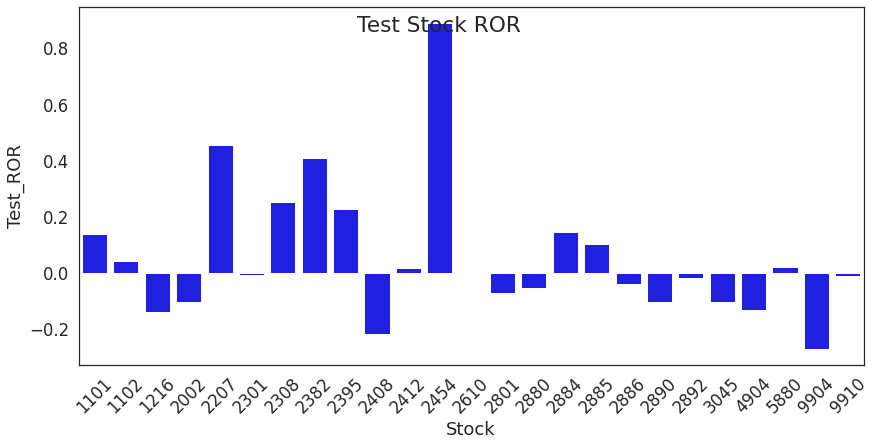

In [ ]:
Test_ROR = load_pickle(os.path.join(gd_root,'Test_ROR.pkl'))
ror_df = pd.DataFrame(Test_ROR.items(), columns = ['Stock','Test_ROR'])

sns.set(style = 'white',font_scale=1.5)
fig, ax = plt.subplots(figsize = (12,6),sharex = True)
fig.suptitle('Test Stock ROR')
ax = sns.barplot(x="Stock", y="Test_ROR", data=ror_df, color = 'blue')
plt.xticks(rotation=45)
plt.tight_layout(pad=0)
plt.savefig('Test Stock ROR.svg', dpi=300)
plt.savefig('Test Stock ROR.jpg')

## Normalization

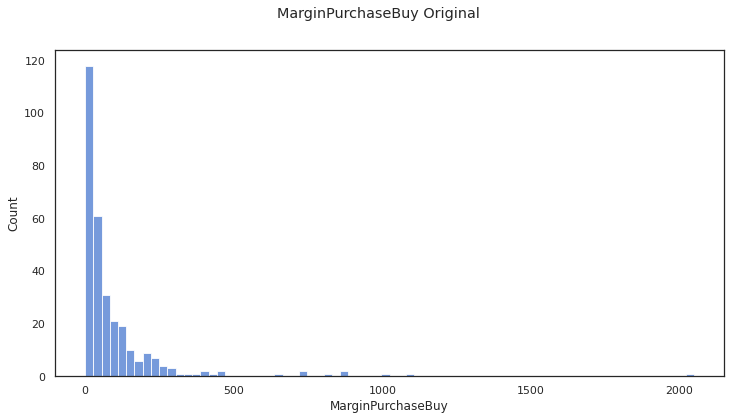

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
fig.suptitle('MarginPurchaseBuy Original')
sns.histplot(bench_df['MarginPurchaseBuy'])

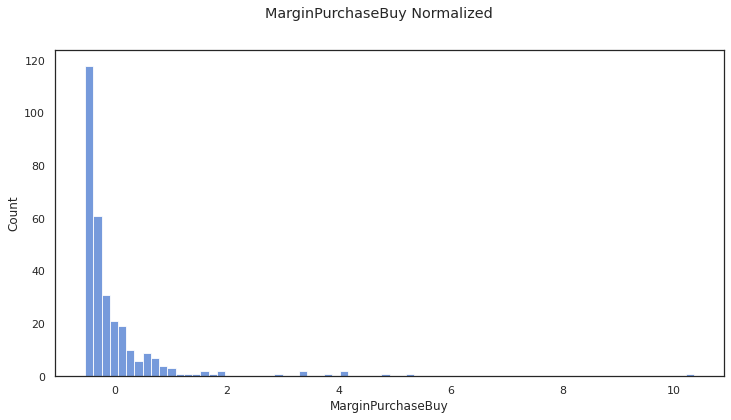

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
fig.suptitle('MarginPurchaseBuy Normalized')
a = bench_df['MarginPurchaseBuy'].mean()
b = bench_df['MarginPurchaseBuy'].std()
sns.histplot(bench_df['MarginPurchaseBuy'].apply(lambda x : (x-a)/b))


## Smoothing Data Plot

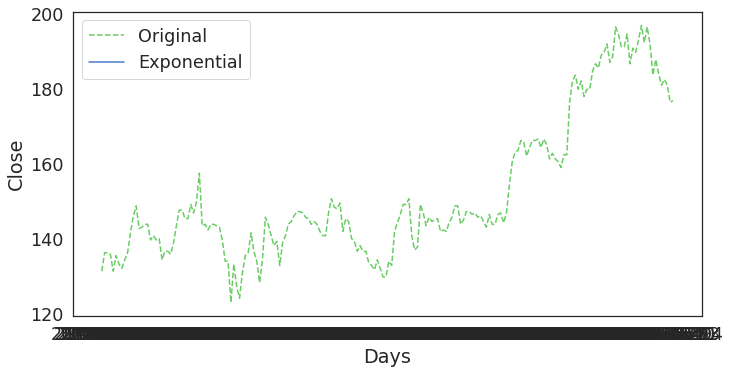

In [ ]:
new_df # expional smooth 過
new_df_ori # 原始

draw = 'Close'
df = pd.concat([new_df[draw], new_df_ori[draw]], axis=1)
df.columns=['exp','ori']
df = df.iloc[-200:]
# display(df.tail())

sns.set(style="white", palette="muted", color_codes=True, font_scale=1.6)

fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
# fig.suptitle(f'Original & Smoothing {draw}')
sns.lineplot(data=df, x=df.index, y='ori', label = 'Original', color='g' ,linestyle='--' ,ax=ax)
sns.lineplot(data=df, x=df.index, y='exp', label = 'Exponential', ax=ax)
# plt.marlegendgins(x=0,y=0)
# plt.(fontsize = 15)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Days")
plt.ylabel(f"{draw}")
plt.tight_layout(pad=0)
plt.savefig('smoothing.svg', dpi=300)
plt.savefig('smoothing.jpg')


# Keep Colab Working


In [ ]:
import datetime
import time
counter = 0
print(datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'),'start keeping working')
while 1:
    counter+=1
    print('\r this is {} times '.format(counter),end='')
    time.sleep(60*10)
    if counter >= 60:
        break
print('loop more than 60 times, let colab sleep')

2021/08/10 15:02:38 start keeping working
 this is 5 times 

KeyboardInterrupt: ignored